In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests, json, csv

%matplotlib inline

## Reading data

In [2]:
# Accident file
crash_2018 = pd.read_csv('data/crash/2018/ACCIDENT.csv')
crash_2018.columns = crash_2018.columns.str.lower()

# Vehicle file
crash_vehicle_2018 = pd.read_csv('data/crash/2018/VEHICLE.csv')
crash_vehicle_2018.columns = crash_vehicle_2018.columns.str.lower()

# Vindecode file is not released yet!
# # Vindecode file
# vindecode_2018 = pd.read_csv('data/crash/2018/VINDECODE.csv')
# vindecode_2018.columns = vindecode_2018.columns.str.lower()

# Factor file
crash_factor_2018 = pd.read_csv('data/crash/2018/FACTOR.csv')
crash_factor_2018.columns = crash_factor_2018.columns.str.lower()

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (26,27,74) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
pd.set_option('display.max_columns', 200) # to display all 51 columns 
crash_2018.head()

,casenum,region,psu,pj,psu_var,urbanicity,stratum,ve_total,ve_forms,pvh_invl,peds,permvit,pernotmvit,num_inj,month,year,day_week,hour,minute,harm_ev,alcohol,max_sev,man_coll,reljct1,reljct2,typ_int,wrk_zone,rel_road,lgt_cond,weather1,weather2,weather,sch_bus,int_hwy,cf1,cf2,cf3,wkdy_im,hour_im,minute_im,event1_im,mancol_im,reljct1_im,reljct2_im,lgtcon_im,weathr_im,maxsev_im,no_inj_im,alchl_im,psustrat,weight
0,201800381338,4,56,208,208,1,9,4,4,0,0,4,0,0,1,2018,4,8,0,12,2,0,1,0,1,1,0,1,1,1,0,1,0,1,0,0,0,4,8,0,12,1,0,1,1,1,0,0,2,20,187.193308
1,201800381366,4,56,214,214,1,7,3,3,0,0,3,0,1,1,2018,3,14,45,12,2,1,1,0,1,1,0,1,1,1,0,1,0,0,0,0,0,3,14,45,12,1,0,1,1,1,1,1,2,20,149.787336
2,201800381374,4,56,214,214,1,6,2,2,0,0,3,0,2,1,2018,4,17,46,12,2,1,7,0,1,1,0,3,2,1,0,1,0,1,19,0,0,4,17,46,12,7,0,1,2,1,1,2,2,20,76.421258
3,201800383118,4,56,209,209,1,10,2,2,0,0,2,0,0,1,2018,4,11,44,12,9,0,6,8,2,2,0,1,1,10,0,10,0,0,0,0,0,4,11,44,12,6,0,2,1,10,1,1,2,20,265.232273
4,201800383942,4,64,306,64,1,6,2,2,0,0,3,0,1,1,2018,2,16,25,12,2,1,7,0,1,1,0,1,1,10,0,10,0,1,0,0,0,2,16,25,12,7,0,1,1,10,1,1,2,23,78.134540


#### Quick look at the years of vehicles

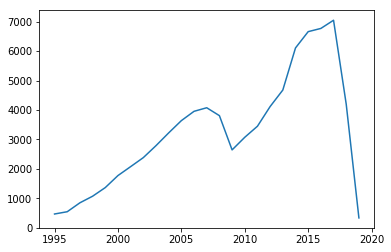

In [4]:
plt.plot(crash_vehicle_2018.mod_year.value_counts()[crash_vehicle_2018.mod_year.value_counts().index.isin(range(1995,2020))].sort_index().index, 
         crash_vehicle_2018.mod_year.value_counts()[crash_vehicle_2018.mod_year.value_counts().index.isin(range(1995,2020))].sort_index())

#### Finding 1:

The number of 2008-2011 year vehicles are lower than expected. It must be related with financial crisis of 2007-2008 and its long-term effects

### Initial filtering

#### Filter 1

I just want to look automobiles(small sport to family van) and small pickups. So here, busses and bigger vehicles are excluded.

In [5]:
filtered_crash_vehicle_2018 = crash_vehicle_2018[(crash_vehicle_2018.body_typ<50) & ~(crash_vehicle_2018.body_typ.isin([21, 22, 28, 29]))]

#### Filter 2

Also, since vehicle make and model names come from vin decoding, if the vin is not valid these vehicles are excluded.

In [6]:
filtered_crash_vehicle_2018 = filtered_crash_vehicle_2018[~(crash_vehicle_2018.vin.isin(['888888888888', '999999999999', '000000000000']))]

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


#### Filter 3

Since I will rate the maximum sverity of injury, I will filter out if the injury occured prior to crash or there is no person involved.

In [7]:
filtered_crash_vehicle_2018 = filtered_crash_vehicle_2018[filtered_crash_vehicle_2018.mxvsev_im<6]

#### Filter 4

Since I am looking what percentage of all occupants in a vehicle is injured, I will filter out if the number of occupants is unknown.

In [8]:
filtered_crash_vehicle_2018 = filtered_crash_vehicle_2018[filtered_crash_vehicle_2018.numoccs<98]

Dropping irrelevant or not useful columns

In [9]:
filtered_crash_vehicle_2018.columns

Index(['casenum', 'veh_no', 'region', 'psu', 'pj', 'psu_var', 'urbanicity',
       'stratum', 've_forms', 'numoccs', 'month', 'hour', 'minute', 'harm_ev',
       'man_coll', 'unittype', 'hit_run', 'make', 'model', 'body_typ',
       'mod_year', 'mak_mod', 'vin', 'tow_veh', 'j_knife', 'mcarr_i1',
       'mcarr_i2', 'mcarr_id', 'gvwr', 'v_config', 'cargo_bt', 'haz_inv',
       'haz_plac', 'haz_id', 'haz_cno', 'haz_rel', 'bus_use', 'spec_use',
       'emer_use', 'trav_sp', 'rollover', 'rolinloc', 'impact1', 'deformed',
       'towed', 'm_harm', 'veh_sc1', 'veh_sc2', 'veh_alch', 'max_vsev',
       'num_injv', 'fire_exp', 'dr_pres', 'dr_zip', 'speedrel', 'dr_sf1',
       'dr_sf2', 'dr_sf3', 'dr_sf4', 'vtrafway', 'vnum_lan', 'vspd_lim',
       'valign', 'vprofile', 'vsurcond', 'vtrafcon', 'vtcont_f', 'p_crash1',
       'p_crash2', 'p_crash3', 'pcrash4', 'pcrash5', 'acc_type', 'trlr1vin',
       'trlr2vin', 'trlr3vin', 'hitrun_im', 'bdytyp_im', 'mdlyr_im',
       'impact1_im', 'vevent_im', 'p

In [10]:
filtered_crash_vehicle_2018 = filtered_crash_vehicle_2018.drop(
    columns=['psu', 'pj', 'stratum', 'unittype', 'hit_run', 'make', 'model', 
             'mod_year', 'body_typ','impact1', 'm_harm', 'veh_alch', 'max_vsev',
             'num_injv', 'mak_mod', 'tow_veh', 'j_knife', 'mcarr_i1', 'mcarr_i2', 
             'gvwr', 'v_config', 'cargo_bt', 'haz_inv', 'haz_plac', 'haz_id', 
             'haz_cno', 'haz_rel','bus_use', 'spec_use', 'emer_use', 'towed', 
             'veh_sc1', 'veh_sc2', 'mcarr_id', 'dr_pres', 'dr_sf1', 'dr_sf2', 
             'dr_sf3', 'dr_sf4','vtrafcon', 'vtcont_f', 'p_crash1', 'p_crash2', 
             'p_crash3', 'pcrash4', 'pcrash5', 'trlr1vin', 'trlr2vin', 'trlr3vin', 
             'hitrun_im', 'urbanicity', 'region', 'psustrat', 'psu_var', 'weight'])

The next cell is to get make, model and trim data from vin by using api from nhtsa website.

block = 500

url = 'https://vpic.nhtsa.dot.gov/api/vehicles/DecodeVINValuesBatch/'

file_path = 'data/vin_2018_batch.txt'

vindecode_2018 = pd.DataFrame()

def save_json(r):

    with open(file_path, 'w') as outfile:
        json.dump(r.json()['Results'], outfile)

def vin_df(vin_list):
    
    post_fields = {'format': 'json', 'data':vin_list}
    r = requests.post(url, data=post_fields)
    save_json(r)
        
    return pd.read_json(file_path)[['VIN','Make','Model','ModelYear','Trim']]

def vin_listing(i):

    return ';'.join(filtered_crash_vehicle_2018.head(block*(i+1)).tail(block).vin.values)

for i in range(int(len(filtered_crash_vehicle_2018)/block)+1):
    
    vindecode_2018 = vindecode_2018.append(vin_df(vin_listing(i)))

vindecode_2018.to_csv('data/crash/vindecode_2018.csv', index=False)

vindecode_2018

In [11]:
vindecode_2018 = pd.read_csv('data/crash/vindecode_2018.csv')
vindecode_2018.columns = ['vin', 'vinmake_t', 'vinmodel_t', 'vinyear', 'vintrim_t']
vindecode_2018.vinmodel_t = vindecode_2018.vinmodel_t.str.upper()
vindecode_2018.vintrim_t = vindecode_2018.vintrim_t.str.upper()
vindecode_2018.vinmake_t = np.where(vindecode_2018.vinmake_t=='HUMMER ', 'HUMMER', vindecode_2018.vinmake_t)
vindecode_2018.head()

,vin,vinmake_t,vinmodel_t,vinyear,vintrim_t
0,5TBJU32155S4,TOYOTA,TUNDRA,2005.0,DX
1,1G1RC6S5XHU1,CHEVROLET,VOLT,2017.0,NaN
2,1FTRW12W77KC,FORD,F-150,2007.0,NaN
3,1C4SDHCT7GC4,DODGE,DURANGO,2016.0,R/T
4,1C3CCCBB9FN5,CHRYSLER,200,2015.0,200S


In [12]:
vindecode_2018.to_csv('data/crash/2018/VINDECODE.CSV', index=False)

### Merging files

Taking the vehicle make and model names from vindecode file

Firstly concatanating the make and model names

In [13]:
vindecode_2018['make_model'] = vindecode_2018.vinmake_t + ' ' + vindecode_2018.vinmodel_t

Merging and getting make_model column

In [14]:
filtered_crash_vehicle_2018 = pd.merge(filtered_crash_vehicle_2018, vindecode_2018, on=['vin'], how='inner').rename(columns={'vinmake_t':'make', 'vinmodel_t':'model', 'vintrim_t':'trim'})

Taking factors from factor file which is vehicle’s possible pre-existing defects or maintenance conditions that may have contributed to the crash

In [15]:
filtered_crash_vehicle_2018 = pd.merge(filtered_crash_vehicle_2018, crash_factor_2018[['casenum', 'veh_no', 'mfactor']], on=['casenum', 'veh_no'], how='inner')

Taking wheather and light coditions from accident file which may have contributed to the crash

In [16]:
filtered_crash_vehicle_2018 = pd.merge(filtered_crash_vehicle_2018, crash_2018[['casenum', 'weathr_im', 'lgtcon_im']], on='casenum', how='inner')

#### Filter 5

I will choose the rows with make information

In [17]:
filtered_crash_vehicle_2018 = filtered_crash_vehicle_2018.dropna(subset=['make']).reset_index(drop=True)

#### Filter 6

Some make values are not decoded properly. It shows the make group instead of a certain make. So I will drop these columns.

In [18]:
filtered_crash_vehicle_2018 = filtered_crash_vehicle_2018[~filtered_crash_vehicle_2018.make.str.contains(',')].reset_index(drop=True)

#### Filtering result:

In [19]:
print('I will use ' + str(round(filtered_crash_vehicle_2018.shape[0]/crash_vehicle_2018.shape[0]*100, 2)) + ' percent of the data for 2018')

I will use 105.86 percent of the data for 2018


## Damage to people / first level

#### Quantizing the severity of damage to people in a vehicle

Here, I need to create a column which will show the severity of damage from 100 (fatal) to 0 (no injury)

Assumption: Injured, Severity Unknown must be in between "Minor Injury" (50) and "Serious Injury" (75). Hence it is quantized as 65

In [20]:
filtered_crash_vehicle_2018['inj_sev_rate'] = np.where(filtered_crash_vehicle_2018.mxvsev_im<5, 25*filtered_crash_vehicle_2018.mxvsev_im, 65)

In [21]:
# The numbers of each injury severity levels
filtered_crash_vehicle_2018.inj_sev_rate.value_counts()

0      63595
25     14266
50      7303
75      4918
100      804
65       267
Name: inj_sev_rate, dtype: int64

#### Grouping by make_models

In [22]:
avg_inj_sev = filtered_crash_vehicle_2018[['make_model', 'inj_sev_rate', 'vinyear']].groupby('make_model').agg(['mean', 'count'])
avg_inj_sev.columns = ['avg_inj_sev', 'number_of_accidents', 'avg_mod_year', 'count']
avg_inj_sev = avg_inj_sev.drop(columns='count')
avg_inj_sev.avg_mod_year = round(avg_inj_sev.avg_mod_year, 1)
avg_inj_sev = avg_inj_sev.sort_values('avg_inj_sev',ascending=True)
avg_inj_sev = avg_inj_sev.reset_index()

#### Question:

What should be the minimum sample number to be able to speak statistically a make/model is safe or not?

In [23]:
# Sample number of specific make/model
n = 45
avg_inj_sev[avg_inj_sev.number_of_accidents>n].head()

,make_model,avg_inj_sev,number_of_accidents,avg_mod_year
178,MERCURY MILAN,5.392157,51,2008.2
179,RAM 2500,5.494505,91,2015.6
200,DODGE CHALLENGER,6.807512,213,2014.7
203,INFINITI Q50,6.834532,139,2015.4
212,TOYOTA COROLLA MATRIX,7.258065,93,2006.3


#### Problem:

This maximum severity of injury shows only the severity of the most injured person in a vehicle.

Another important factor is what percentage of people in vehicle got injured?

#### Possible solution:

Creating weighted severity of injury: inury severity * number of injured / number of occupants  

In [24]:
# This metric is basically looks what percentage of the occupants got injured and what is the maximum injury
filtered_crash_vehicle_2018['weighted_inj_sev_rate'] = filtered_crash_vehicle_2018.inj_sev_rate*filtered_crash_vehicle_2018.numinj_im/filtered_crash_vehicle_2018.numoccs

# I do not want that the minimum value of this rate to be 0. Because I will make calculations to measure safety of the vehicles
# and if minimum will be zero, it could not help when comparing different conditions 
# filtered_crash_vehicle_2018.weighted_inj_sev_rate = np.where(filtered_crash_vehicle_2018.weighted_inj_sev_rate==0, 3,
#                                                             filtered_crash_vehicle_2018.weighted_inj_sev_rate)

filtered_crash_vehicle_2018.head()

,casenum,veh_no,ve_forms,numoccs,month,hour,minute,harm_ev,man_coll,vin,trav_sp,rollover,rolinloc,deformed,fire_exp,dr_zip,speedrel,vtrafway,vnum_lan,vspd_lim,valign,vprofile,vsurcond,acc_type,bdytyp_im,mdlyr_im,impact1_im,vevent_im,pcrash1_im,mxvsev_im,numinj_im,v_alch_im,make,model,vinyear,trim,make_model,mfactor,weathr_im,lgtcon_im,inj_sev_rate,weighted_inj_sev_rate
0,201800381374,1,2,2,1,17,46,12,7,5TBJU32155S4,60,0,0,4,0,91007,0,3,4,65,8,8,1,48,34,2005,83,12,1,1,1,2,TOYOTA,TUNDRA,2005.0,DX,TOYOTA TUNDRA,0,1,2,25,12.5
1,201800381374,2,2,1,1,17,46,12,7,1G1RC6S5XHU1,60,0,0,6,0,91016,0,3,4,65,8,8,1,48,5,2017,61,12,1,1,1,2,CHEVROLET,VOLT,2017.0,NaN,CHEVROLET VOLT,0,1,2,25,25.0
2,201800381374,2,2,1,1,17,46,12,7,1G1RC6S5XHU1,60,0,0,6,0,91016,0,3,4,65,8,8,1,48,5,2017,61,12,1,1,1,2,CHEVROLET,VOLT,2017.0,NaN,CHEVROLET VOLT,0,1,2,25,25.0
3,201800836006,1,2,1,7,7,35,12,7,1G1RC6S5XHU1,23,0,0,4,0,95661,0,2,5,65,8,8,1,44,5,2017,81,12,1,0,0,2,CHEVROLET,VOLT,2017.0,NaN,CHEVROLET VOLT,0,1,1,0,0.0
4,201800836006,1,2,1,7,7,35,12,7,1G1RC6S5XHU1,23,0,0,4,0,95661,0,2,5,65,8,8,1,44,5,2017,81,12,1,0,0,2,CHEVROLET,VOLT,2017.0,NaN,CHEVROLET VOLT,0,1,1,0,0.0


In [25]:
avg_wgh_inj_sev = filtered_crash_vehicle_2018[['make_model', 'weighted_inj_sev_rate', 'vinyear']].groupby('make_model').agg(['mean', 'count'])
avg_wgh_inj_sev.columns = ['avg_wgh_inj_sev', 'number_of_accidents', 'avg_mod_year', 'count']
avg_wgh_inj_sev = avg_wgh_inj_sev.drop(columns='count')
avg_wgh_inj_sev.avg_mod_year = round(avg_wgh_inj_sev.avg_mod_year, 1)
avg_wgh_inj_sev = avg_wgh_inj_sev.sort_values('avg_wgh_inj_sev',ascending=True)
avg_wgh_inj_sev = avg_wgh_inj_sev.reset_index()

In [26]:
avg_wgh_inj_sev[avg_wgh_inj_sev.number_of_accidents>n].head()

,make_model,avg_wgh_inj_sev,number_of_accidents,avg_mod_year
173,MERCURY MILAN,4.370915,51,2008.2
174,RAM 2500,4.464286,91,2015.6
209,MAZDA CX-9,6.044601,71,2013.3
214,TOYOTA COROLLA MATRIX,6.182796,93,2006.3
215,DODGE CHALLENGER,6.210876,213,2014.7


I need to go deeper since it is obvious that not all the accident conditions are exact same. I should compare similiar conditions and results in order to see more accurate. Hence I need to create another level which will show the condition in which crash occured.

**Saving the crash file for 2018**

In [27]:
filtered_crash_vehicle_2018.to_csv('data/crash/crash_2018.csv',index=False)

## Crash condition / second level

In [28]:
# Creating new column to display and categorize travel speeds as multiples of 5 i.e. [0-5)-> 0, [5-10)-> 5, [10-15)-> 10, ... mph 

# speed_interval = pd.interval_range(start=0, freq=5, end=150, closed='left')
# speed_list=[]
# for i in range(0,150,5): speed_list.append(i)
# filtered_crash_vehicle_2018['travel_speed'] = np.where(filtered_crash_vehicle_2018.trav_sp==997, 
#                                                        160,
#                                                        pd.cut(filtered_crash_vehicle_2018.trav_sp, bins=speed_interval).apply(lambda x: x.left)
#                                                       )
# filtered_crash_vehicle_2018.travel_speed = filtered_crash_vehicle_2018.travel_speed.fillna(999).astype(int)

# Doing the same work:

filtered_crash_vehicle_2018['travel_speed'] = (filtered_crash_vehicle_2018.trav_sp/5).astype(int)*5

In [29]:
# The number of vehicles older than 1989 is lower than 100, so I want to group them to see if there is a correlation between year and damage
# Creating new column to display model years of old cars as group:
# [:,1970)-> 1960, [1970,1980)-> 1970, [1980-1990)->1980

filtered_crash_vehicle_2018['year'] = np.where(filtered_crash_vehicle_2018.mdlyr_im<1990,
                                               (filtered_crash_vehicle_2018.mdlyr_im/10).astype(int)*10,
                                               filtered_crash_vehicle_2018.mdlyr_im.astype(int) )

** The conditions that may have huge impact on the damage resulted. I want to see their effects and then isolate that effect if I could.**

In [30]:
filtered_crash_vehicle_2018.columns

Index(['casenum', 'veh_no', 've_forms', 'numoccs', 'month', 'hour', 'minute',
       'harm_ev', 'man_coll', 'vin', 'trav_sp', 'rollover', 'rolinloc',
       'deformed', 'fire_exp', 'dr_zip', 'speedrel', 'vtrafway', 'vnum_lan',
       'vspd_lim', 'valign', 'vprofile', 'vsurcond', 'acc_type', 'bdytyp_im',
       'mdlyr_im', 'impact1_im', 'vevent_im', 'pcrash1_im', 'mxvsev_im',
       'numinj_im', 'v_alch_im', 'make', 'model', 'vinyear', 'trim',
       'make_model', 'mfactor', 'weathr_im', 'lgtcon_im', 'inj_sev_rate',
       'weighted_inj_sev_rate', 'travel_speed', 'year'],
      dtype='object')

In [31]:
condition_list = ['weathr_im', 'lgtcon_im',
                  'mfactor', 
                  'vevent_im', 'impact1_im', 
                  'year', 
                  'travel_speed', 
                  'v_alch_im', 
                  'vsurcond' ]

crush_type_list = ['acc_type', 'rollover', 'deformed', 'fire_exp']

condition_list+crush_type_list

['weathr_im',
 'lgtcon_im',
 'mfactor',
 'vevent_im',
 'impact1_im',
 'year',
 'travel_speed',
 'v_alch_im',
 'vsurcond',
 'acc_type',
 'rollover',
 'deformed',
 'fire_exp']

I will create a dataframe which contains all groups of all these categories. Hence I first created a function which group by by a category and returns the counts and avgerage severity of injury for each groups(which is code for each category/data elemnts). Then I merged these data for all conditions.

In [32]:
# This is the average of all conditions in 2018
overall_avg = filtered_crash_vehicle_2018.weighted_inj_sev_rate.describe()[['mean', 'min', '25%', '50%', '75%', 'max']].mean()

# Minimum number of crushes in order to be able to safely say that a condition is more dangerous or safe 
min_cnt = 33

def category_avg(category):
    condition = filtered_crash_vehicle_2018[[category, 'weighted_inj_sev_rate']].groupby(category).describe()
    condition.columns = [category+'_count', 'mean', 'std', 'min', '1q', '2q', '3q', 'max']
    condition[category+'_avg_severity'] = condition[['mean', 'min', '1q', '2q', '3q', 'max']].mean(axis=1)
    condition[category+'_relative_severity'] = (condition[category+'_avg_severity']-overall_avg).round(2)
    condition = condition.drop(columns=[category+'_avg_severity', 'mean', 'std', 'min', '1q', '2q', '3q', 'max']).reset_index()
    condition = condition[condition[category+'_count']>min_cnt].reset_index(drop=True)
    
    return condition

conditions = pd.DataFrame()

for i in range(len(condition_list+crush_type_list)):
    
    conditions = pd.merge(conditions, category_avg((condition_list+crush_type_list)[i]), left_index=True, right_index=True, how='outer')
    
conditions.head()

,weathr_im,weathr_im_count,weathr_im_relative_severity,lgtcon_im,lgtcon_im_count,lgtcon_im_relative_severity,mfactor,mfactor_count,mfactor_relative_severity,vevent_im,vevent_im_count,vevent_im_relative_severity,impact1_im,impact1_im_count,impact1_im_relative_severity,year,year_count,year_relative_severity,travel_speed,travel_speed_count,travel_speed_relative_severity,v_alch_im,v_alch_im_count,v_alch_im_relative_severity,vsurcond,vsurcond_count,vsurcond_relative_severity,acc_type,acc_type_count,acc_type_relative_severity,rollover,rollover_count,rollover_relative_severity,deformed,deformed_count,deformed_relative_severity,fire_exp,fire_exp_count,fire_exp_relative_severity
0,1.0,65822.0,-0.03,1.0,66380.0,-1.56,0.0,77062.0,-0.00,1.0,1614.0,26.94,0.0,622.0,12.08,1980.0,289.0,0.75,0.0,16588.0,-2.58,1.0,2280.0,16.37,0.0,2549.0,-5.20,0,153.0,0.72,0.0,88826.0,-1.55,0.0,1919.0,-5.61,0.0,90974.0,-0.01
1,2.0,9593.0,-0.02,2.0,7237.0,1.12,1.0,363.0,4.87,2.0,71.0,16.95,1.0,4191.0,-1.54,1990.0,70.0,1.39,5.0,4276.0,-5.11,2.0,88873.0,-0.10,1.0,71545.0,0.03,1,2286.0,13.57,1.0,1238.0,27.37,2.0,25900.0,-5.62,1.0,179.0,22.87
2,3.0,145.0,-4.24,3.0,13554.0,0.20,2.0,242.0,-8.90,8.0,1540.0,-5.90,2.0,1237.0,-3.05,1991.0,123.0,0.92,10.0,4307.0,-5.06,NaN,NaN,NaN,2.0,13581.0,0.04,2,1086.0,6.59,2.0,178.0,21.76,4.0,21672.0,-5.15,NaN,NaN,NaN
3,4.0,1462.0,-2.32,4.0,1410.0,0.21,3.0,50.0,-3.54,9.0,1150.0,-14.36,3.0,2515.0,0.36,1992.0,148.0,0.90,15.0,3288.0,-4.75,NaN,NaN,NaN,3.0,949.0,-2.36,3,452.0,0.58,9.0,911.0,26.56,6.0,31302.0,9.44,NaN,NaN,NaN
4,5.0,334.0,1.39,5.0,2064.0,-1.21,14.0,54.0,-13.97,11.0,1840.0,-5.52,4.0,797.0,-3.65,1993.0,171.0,1.26,20.0,2951.0,-4.81,NaN,NaN,NaN,4.0,966.0,-3.34,5,42.0,20.70,NaN,NaN,NaN,8.0,10137.0,-4.67,NaN,NaN,NaN


This 'conditions' dataframe will be used like lookup table. 

In [33]:
def condition_rate(category):
    return conditions[[category, category+'_relative_severity']].dropna()

filtered_crash_vehicle_2018['crash_codition'] = 0

for i in range(len(condition_list)):
    
    filtered_crash_vehicle_2018 = pd.merge(filtered_crash_vehicle_2018, condition_rate(condition_list[i]), on= condition_list[i], how='left')
    
    filtered_crash_vehicle_2018.crash_codition = filtered_crash_vehicle_2018.crash_codition + filtered_crash_vehicle_2018[condition_list[i]+'_relative_severity'].fillna(0)
    
    filtered_crash_vehicle_2018 = filtered_crash_vehicle_2018.drop(columns=condition_list[i]+'_relative_severity')
    
# Crash condition normalization:
filtered_crash_vehicle_2018.crash_codition = 10-20*(filtered_crash_vehicle_2018.crash_codition-filtered_crash_vehicle_2018.crash_codition.min())/(filtered_crash_vehicle_2018.crash_codition.max()-filtered_crash_vehicle_2018.crash_codition.min())

filtered_crash_vehicle_2018.head()

,casenum,veh_no,ve_forms,numoccs,month,hour,minute,harm_ev,man_coll,vin,trav_sp,rollover,rolinloc,deformed,fire_exp,dr_zip,speedrel,vtrafway,vnum_lan,vspd_lim,valign,vprofile,vsurcond,acc_type,bdytyp_im,mdlyr_im,impact1_im,vevent_im,pcrash1_im,mxvsev_im,numinj_im,v_alch_im,make,model,vinyear,trim,make_model,mfactor,weathr_im,lgtcon_im,inj_sev_rate,weighted_inj_sev_rate,travel_speed,year,crash_codition
0,201800381374,1,2,2,1,17,46,12,7,5TBJU32155S4,60,0,0,4,0,91007,0,3,4,65,8,8,1,48,34,2005,83,12,1,1,1,2,TOYOTA,TUNDRA,2005.0,DX,TOYOTA TUNDRA,0,1,2,25,12.5,60,2005,3.514247
1,201800381374,2,2,1,1,17,46,12,7,1G1RC6S5XHU1,60,0,0,6,0,91016,0,3,4,65,8,8,1,48,5,2017,61,12,1,1,1,2,CHEVROLET,VOLT,2017.0,NaN,CHEVROLET VOLT,0,1,2,25,25.0,60,2017,2.328697
2,201800381374,2,2,1,1,17,46,12,7,1G1RC6S5XHU1,60,0,0,6,0,91016,0,3,4,65,8,8,1,48,5,2017,61,12,1,1,1,2,CHEVROLET,VOLT,2017.0,NaN,CHEVROLET VOLT,0,1,2,25,25.0,60,2017,2.328697
3,201800836006,1,2,1,7,7,35,12,7,1G1RC6S5XHU1,23,0,0,4,0,95661,0,2,5,65,8,8,1,44,5,2017,81,12,1,0,0,2,CHEVROLET,VOLT,2017.0,NaN,CHEVROLET VOLT,0,1,1,0,0.0,20,2017,4.092605
4,201800836006,1,2,1,7,7,35,12,7,1G1RC6S5XHU1,23,0,0,4,0,95661,0,2,5,65,8,8,1,44,5,2017,81,12,1,0,0,2,CHEVROLET,VOLT,2017.0,NaN,CHEVROLET VOLT,0,1,1,0,0.0,20,2017,4.092605


In [34]:
filtered_crash_vehicle_2018['damage_over_condition'] = filtered_crash_vehicle_2018.weighted_inj_sev_rate + 2*filtered_crash_vehicle_2018.crash_codition

filtered_crash_vehicle_2018.damage_over_condition = 100*(filtered_crash_vehicle_2018.damage_over_condition-filtered_crash_vehicle_2018.damage_over_condition.min())/(filtered_crash_vehicle_2018.damage_over_condition.max()-filtered_crash_vehicle_2018.damage_over_condition.min())

filtered_crash_vehicle_2018['safety_rate'] = 100-filtered_crash_vehicle_2018.damage_over_condition

filtered_crash_vehicle_2018.head()

,casenum,veh_no,ve_forms,numoccs,month,hour,minute,harm_ev,man_coll,vin,trav_sp,rollover,rolinloc,deformed,fire_exp,dr_zip,speedrel,vtrafway,vnum_lan,vspd_lim,valign,vprofile,vsurcond,acc_type,bdytyp_im,mdlyr_im,impact1_im,vevent_im,pcrash1_im,mxvsev_im,numinj_im,v_alch_im,make,model,vinyear,trim,make_model,mfactor,weathr_im,lgtcon_im,inj_sev_rate,weighted_inj_sev_rate,travel_speed,year,crash_codition,damage_over_condition,safety_rate
0,201800381374,1,2,2,1,17,46,12,7,5TBJU32155S4,60,0,0,4,0,91007,0,3,4,65,8,8,1,48,34,2005,83,12,1,1,1,2,TOYOTA,TUNDRA,2005.0,DX,TOYOTA TUNDRA,0,1,2,25,12.5,60,2005,3.514247,26.733636,73.266364
1,201800381374,2,2,1,1,17,46,12,7,1G1RC6S5XHU1,60,0,0,6,0,91016,0,3,4,65,8,8,1,48,5,2017,61,12,1,1,1,2,CHEVROLET,VOLT,2017.0,NaN,CHEVROLET VOLT,0,1,2,25,25.0,60,2017,2.328697,34.796932,65.203068
2,201800381374,2,2,1,1,17,46,12,7,1G1RC6S5XHU1,60,0,0,6,0,91016,0,3,4,65,8,8,1,48,5,2017,61,12,1,1,1,2,CHEVROLET,VOLT,2017.0,NaN,CHEVROLET VOLT,0,1,2,25,25.0,60,2017,2.328697,34.796932,65.203068
3,201800836006,1,2,1,7,7,35,12,7,1G1RC6S5XHU1,23,0,0,4,0,95661,0,2,5,65,8,8,1,44,5,2017,81,12,1,0,0,2,CHEVROLET,VOLT,2017.0,NaN,CHEVROLET VOLT,0,1,1,0,0.0,20,2017,4.092605,17.703608,82.296392
4,201800836006,1,2,1,7,7,35,12,7,1G1RC6S5XHU1,23,0,0,4,0,95661,0,2,5,65,8,8,1,44,5,2017,81,12,1,0,0,2,CHEVROLET,VOLT,2017.0,NaN,CHEVROLET VOLT,0,1,1,0,0.0,20,2017,4.092605,17.703608,82.296392


In [35]:
avg_safety_rate = filtered_crash_vehicle_2018[['make', 'safety_rate', 'vinyear', 'weighted_inj_sev_rate']].groupby('make').agg(['mean', 'count'])
avg_safety_rate.columns = ['avg_safety_rate', 'number_of_accidents', 'avg_mod_year', 'count', 'weighted_inj_sev_rate', 'cnt']
avg_safety_rate = avg_safety_rate.drop(columns=['count', 'cnt'])
avg_safety_rate.avg_mod_year = round(avg_safety_rate.avg_mod_year, 1)
avg_safety_rate = avg_safety_rate.sort_values('avg_safety_rate',ascending=True)
avg_safety_rate = avg_safety_rate.reset_index()
avg_safety_rate[avg_safety_rate.number_of_accidents>2].head()

,make,avg_safety_rate,number_of_accidents,avg_mod_year,weighted_inj_sev_rate
1,BENTLEY,28.955138,3,2009.7,66.666667
2,SMART,58.793360,14,2011.1,30.357143
3,ALFA ROMEO,59.157620,4,2017.5,34.375000
5,GEO,65.615487,22,1994.7,23.863636
6,PLYMOUTH,65.904218,30,1998.3,23.125000
